<a href="https://colab.research.google.com/github/love-bees/dataHacker/blob/master/005_GAN_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Variational Autoencoder with Keras

import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K

Using TensorFlow backend.


In [0]:
# Load dataset

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [0]:
# Data setup

width, height = X_train.shape[1], X_train.shape[2]
channels = 1
input_shape = (height, width, channels)

latent_dim = 2

In [0]:
# Reshape data

X_train = X_train.reshape(X_train.shape[0], height, width, channels)
X_test = X_test.reshape(X_test.shape[0], height, width, channels)

# Normalize data

X_train = X_train / 255.
X_test = X_test / 255.

In [0]:
# Encoder

encoder_input   = Input(shape=input_shape, name='Encoder_input')
conv            = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(encoder_input)
conv            = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(conv)
layer           = Flatten()(conv)
layer           = Dense(16, activation='relu')(layer)
mu              = Dense(latent_dim, name='Mu')(layer)
sigma           = Dense(latent_dim, name='Sigma')(layer)

In [0]:
# Get Conv2D shape for Conv2DTranspose operation in decoder

conv_shape = K.int_shape(conv)

In [0]:
# Define sampling

def sample_z(args):  
    mu, sigma = args  
    batch = K.shape(mu)[0]  
    dim = K.int_shape(mu)[1]  
    eps = K.random_normal(shape=(batch, dim))  
    return mu + K.exp(sigma * 0.5) * eps

In [0]:
# Use reparameterization to generate the output layer with correct gradient

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [0]:
# Putting mu, sigma and z as the encoder output

encoder_output = [mu, sigma, z]

In [10]:
# Instantiate encoder

encoder = Model(encoder_input, encoder_output, name='Encoder')
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         Encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
# Decoder

decoder_input   = Input(shape=(latent_dim, ), name='decoder_input')
layer           = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(decoder_input)
layer           = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(layer)
conv            = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(layer)
conv            = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same',  activation='relu')(conv)
decoder_output  = Conv2DTranspose(channels, kernel_size=3, padding='same', activation='sigmoid', name='decoder_output')(conv)

In [12]:
# Instantiate decoder

decoder = Model(decoder_input, decoder_output, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [13]:
# Putting together the VAE
vae_outputs = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
Encoder (Model)              [(None, 2), (None, 2), (N 69076     
_________________________________________________________________
Decoder (Model)              (None, 28, 28, 1)         65089     
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Define loss

def kl_reconstruction_loss(true, pred):

    # Reconstruction loss  
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * width * height  
    
    # KL divergence loss  
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)  
    kl_loss = K.sum(kl_loss, axis=-1)  
    kl_loss *= -0.5  
    
    # Total loss = 0.5 rec + 0.5 KL divergence loss  
    return K.mean(reconstruction_loss + kl_loss)

In [15]:
# Compile VAE
vae.compile(optimizer='adam', 
            loss=kl_reconstruction_loss)
# Train autoencoder
vae.fit(X_train, X_train, 
        epochs = 10, 
        batch_size = 128, 
        validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 85s 2ms/step - loss: 219.3435 - val_loss: 194.5158
Epoch 2/10
48000/48000 [==============================] - 84s 2ms/step - loss: 185.6398 - val_loss: 175.6777
Epoch 3/10
48000/48000 [==============================] - 85s 2ms/step - loss: 172.0889 - val_loss: 169.0168
Epoch 4/10
48000/48000 [==============================] - 85s 2ms/step - loss: 167.0201 - val_loss: 164.9009
Epoch 5/10
48000/48000 [==============================] - 85s 2ms/step - loss: 164.0188 - val_loss: 162.6776
Epoch 6/10
48000/48000 [==============================] - 85s 2ms/step - loss: 161.9816 - val_loss: 160.2524
Epoch 7/10
48000/48000 [==============================] - 85s 2ms/step - loss: 160.6091 - val_loss: 159.3354
Epoch 8/10
48000/48000 [==============================] - 85s 2ms/step - loss: 159.5505 - val_loss: 158.5801
Epoch 9/10
48000/48000 [==============================] - 85s 2ms/step - loss:

In [0]:
# Plotting the results

def plotter_latent_space(encoder, data):  
    input_data, target_data = data  
    mu, _, _ = encoder.predict(input_data)  
    plt.figure(figsize=(12, 10))  
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)  
    plt.xlabel('z - dim 1')  
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

In [0]:
def images_decoded(encoder, decoder, data):  

    num_samples = 15

    figure = np.zeros((width * num_samples, height * num_samples, channels))  
    
    grid_x = np.linspace(-4, 4, num_samples)  
    grid_y = np.linspace(-4, 4, num_samples)[::-1]  
    
    for i, yi in enumerate(grid_y):      
        for j, xi in enumerate(grid_x):          
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)          
            digit = x_decoded[0].reshape(width, height, channels)          
            figure[i * width : (i + 1) * width, j * height : (j + 1) * height,] = digit
    
    plt.figure(figsize=(12, 10))  
    
    start_range = width // 2  
    end_range = num_samples * width + start_range + 1  
    pixel_range = np.arange(start_range, end_range, width)  
    
    sample_range_x = np.round(grid_x, 1)  
    sample_range_y = np.round(grid_y, 1)  
    
    plt.xticks(pixel_range, sample_range_x)  
    plt.yticks(pixel_range, sample_range_y)  
    
    plt.xlabel('z - dim 1')  
    plt.ylabel('z - dim 2')
    
    fig_shape = np.shape(figure)  
    
    if fig_shape[2] == 1:    
        figure = figure.reshape((fig_shape[0], fig_shape[1]))  

    plt.imshow(figure, cmap='Greys_r')  
    plt.show()

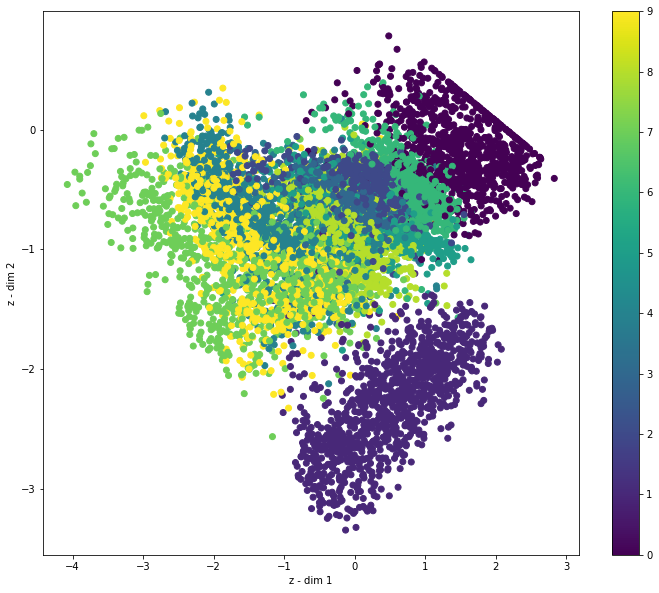

In [35]:
# Plot results
data = (X_test, y_test)
plotter_latent_space(encoder, data)

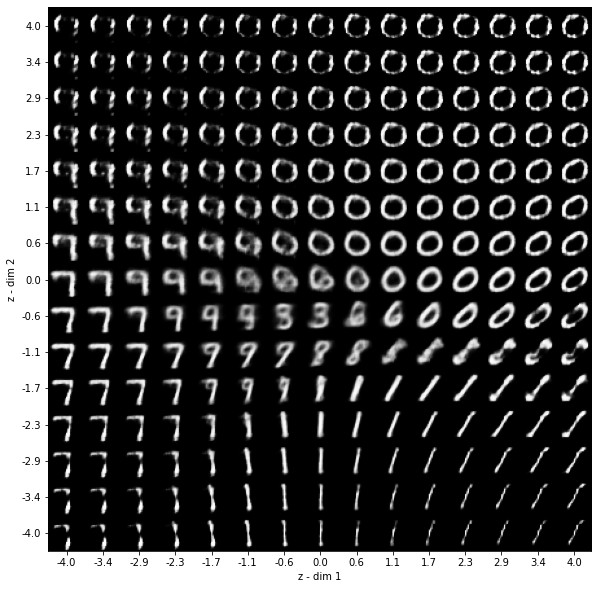

In [31]:
images_decoded(encoder, decoder, data)

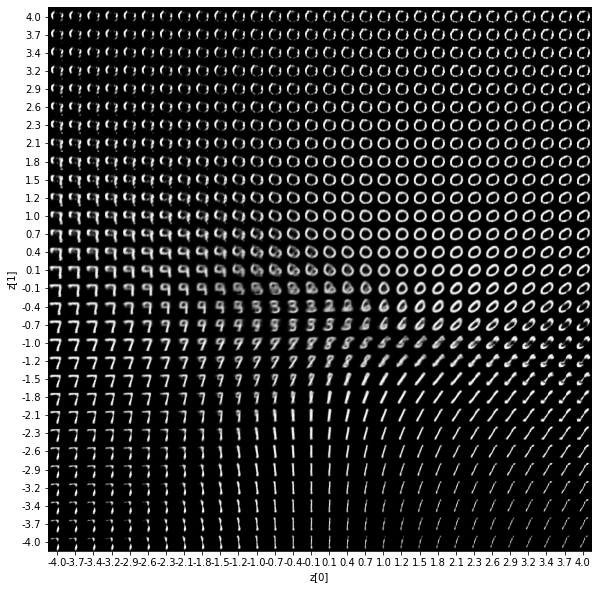

In [32]:
import matplotlib.pyplot as plt

def plot_latent(encoder, decoder):
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

plot_latent(encoder, decoder)